# MA934  Numerical Methods - Workbook 2

In [1]:
using Plots
font1 = Plots.font("Helvetica", 12)
pyplot(guidefont=font1, xtickfont=font1, ytickfont=font1, legendfont=font1)
pyplot()
using LaTeXStrings
include("MODULES/kvpair.jl")
include("MODULES/llist.jl")
include("MODULES/ftree.jl")

normal (generic function with 1 method)

In [81]:
include("MODULES/MyUtils_wb2.jl")

normal (generic function with 1 method)

## Question 1: Linear search using a linked list

The file KVPair.jl defines a simple data structure to represent an (Int64, Float64) key-value pair. 

The file LList.jl defines a linked list that stores a KVPair at each node. Many languages have a keyword NULL. A pointer to any object can take the value NULL to indicate that it doesn't point to anything. NULL is often used to denote the end of a list, the leaves of a tree etc. Julia does not support NULL pointers. This causes a difficulty in implementing recursive data structures. Instead Julia provides a parametric data type Nullable{T} to represent missing values. It is possible to use Nullable types to define recursive data structures although some of the resulting definitions are a bit clumsy. I'm not sure that this is the canonical way to implement structural recursion in Julia. 

The following points are important:

* if a variable has type Nullable{T} then it can either contain a value of type T or nothing (ie a missing value). 
* the function isnull(x) checks whether a nullable type x has a value or not. 
* the function get(x) returns the actual value (of type T) contained in a nullable type x.

Much more information can be found at https://docs.julialang.org/en/stable/manual/types/

The function 

> buildLList(dataArray::Array{KVPair, 1})

takes an array of KVPair objects as input and returns an LList containing these KVPairs. This is illustrated in the code below.

1. Write a recursive function that traverses the list and prints out the key-value pairs stored in it. Check that your function works.
2. Write a function search(list::Nullable{LList}, k::Int64) that searches an LList for the key k and returns the corresponding KVPair if it is present and a Nullable{KVPair} otherwise. Verify that your function works.
3. Use Julia's @timed macro to measure how the typical computational cost of your search() function grows with the length of the list. 

#### Question 1 Part 1
We first use the function "create_KVPairs" which takes the desired number of key value pairs as an input argument and outputs an array of KVPairs. The function "buildLList" then uses the array of KVPairs to build a list. The recursive function "list_traverse" takes a list as an input argument and prints the key of every key value pair. As the output is in ascending order, we know (due to the construction of the list) that the function is working correctly.

In [ ]:
values=create_KVPairs(20)  #NUMBER 1.1 IN FILE
L=buildLList(values);

In [ ]:
function list_traverse(LList::Nullable{LList})  #the input needs to be of the type "Nullable{LList}" #NUMBER 1.2 IN FILE
    L=LList
    k=get(L).data  #k=key value pair of the list
    k1=k.key       # k = key of the list 
    println(k1)    # print the key
    L=get(L).next  # let L be the list that is stored in LList
    if isnull(L)==false # if L is not null, we want to repeat the process (recursive function)
         list_traverse(L)
    end    
    end;

In [ ]:
list_traverse(L)

#### Question 1 Part 2 
The recursive function "list_search" takes a list and an integer as input values and returns the matching KVPair. The function "working_search", which takes the desired list length as an input argument, checks that the function "list_search" works correctly. A detailed description of how this function works is given in the file "MODULES/MyUtils_wb2.jl". 

In [ ]:
function list_search(LList::Nullable{LList}, a::Int64) #the input needs to be of the type "Nullable{LList}", "Int64" #NUMBER 1.3 IN FILE
    L=LList
    k=get(L).data #k=key value pair of the list
    k1=k.key      # k1 = key of the list 
    if (k1 == a)  # if the key is the one we're looking for, return the key value pair k
        return(k)
    else
        L=get(L).next # else update the list and repeat the process (recursive function)
        list_search(L,a)    
    end
end

In [ ]:
working_search(50) #NUMBER 1.4 IN FILE

#### Question 1 Part 3
Now we want to evaluate how the computational cost of the "list_search" function grows with the length of the list. To do that, we consider lists with 1 to 600 KVPairs. For a fixedlist length we search once for every possible key, as the running time doesn't only depend on the list size but also on the key we pick to search for. We then take the mean of the needed times for these searches as y-value for the associated list length. 

The gradient of the best fit line is
8.651218953948157e-9



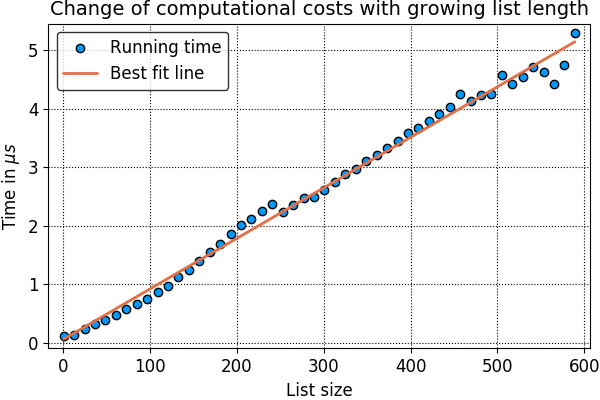

In [71]:
n=600
x=1:12:n
Time=Cost_List_search(x) #NUMBER 1.5 IN FILE

a,b=linreg(x,Time)
println("The gradient of the best fit line is")
println(b)
scatter(x,Time*1e6, linewidth=2,label="Running time",xlabel="List size",ylabel=L"Time in $\mu s$",title="Change of computational costs with growing list length",markersize=6)
plot!(x,(b*x+a)*1e6,linewidth=2,label="Best fit line")

We plot on a lin/lin plot and fit the best fit line. The plot shows that the computational cost of the list search grows linearly. 

## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ interval by a variant of linear search in $O(n)$ time. We will demonstrate below that it can be solved in $O(\log\, n)$ time using a variant of a data structure known as a Fenwick tree.

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1 as shown: 

In [ ]:
# Set number of intervals
n=10
# Seed for random number generator. 
# You should choose your own seed so that everyone does not end up with the same random sequences
seed = 1235 
# Initialise the random number generator
rng = MersenneTwister(seed)
# Generate a sample of n uniform random numbers in the interval [0,1]
X = rand(rng, n);

The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the objects defined in KVPair.jl and LList.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function

$$\text{intervalmembership(list::Nullable{LList}, x::Float64)}$$

that takes the LList containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to measure how the typical computational cost grows with $n$. 

**3)** The file FTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function 

$$\text{buildFTree(T::Nullable{FTree}, dataArray::Array{KVPair, 1})}$$

takes the array of KVPairs containing the interval lengths as input, recursively constructs the tree and returns the FTree containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes).

In [ ]:
n=5
X = rand(rng, 5)
# Now calculate the array of partial sums
values = Array{KVPair}(5)
for i in 1:n
    values[i] = KVPair(i,X[i])
end
T = Nullable{FTree}(FTree(KVPair(0,0.0)))
T=buildFTree(T, values)

Write a recursive function

$$\text{intervalmembership(FT::Nullable{FTree}, x::Float64)}$$

that takes the FTree containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

#### Question 2 Part 1 
The function "create_KVPairs_partial_sums" takes the desired number of intervals as input argument. It then generates a random array X of length n and calculates the value of key value pair i as the cumulative sum of the first i entries of the array X. We then use the function "buildLList" to turn the generated array into a list.

In [ ]:
function create_KVPairs_partial_sums(n)#desired number of intervals   ##NUMBER 2.1 IN FILE
    seed = 1235 
    rng = MersenneTwister(seed)
    X = rand(rng, n)                    #random array of length n
    values = Array{KVPair}(n)           #empty array with n KVPairs
    for i in 1:n                     
        x=sum(X[1:i])                   #compute the cumulative sum of the first i values of X
        values[i]=KVPair(i,x)           # define the KV pair
    end
    return values                       #return the array of KVPairs
end;

In [ ]:
values=create_KVPairs_partial_sums(5)
L=buildLList(values)

To check that the function works, we print the values of the list and the cumulative sums of the random array X for a small value of n (n=5). We see that the function is working correctly.

In [ ]:
for i=1:length(values)
   println(list_search(L,i).value)
    println(values[i].value) 
end

#### Question 2 Part 2 
We introduce the recursive function "intervalmembership" that takes a list and a Float64 as input arguments. We then compare x to the value of the key value pair at the top of the list. If the input value x (Float64) is smaller than the value of the key value, the value x is in the corresponing interval and the search is finished. Else we move to the next element of the list and repeat the search. We check for a small value of n (n=10) that the function works.

In [ ]:
function intervalmembership(list::Nullable{LList},x::Float64) #The input has to be a Nullable{LList} and a Float64  #NUMBER 2.2 IN FILE
    L=list
    k=get(L).data   #k is the key value pair at the top of the list (corresponding to the first interval)
    k2=k.value      #k2 is the upper interval border
    if (x < k2)     #if x is smaller than the interval border, it is in the interval, return the corresponding KVPair
        return(k)  
        else        #if the x is not smaller than the upper interval border, it has to be in one of the higher intervals 
        L=get(L).next #update the list to the next interval
        intervalmembership(L,x) #repeat the process (recursively)
        
    end
end;

In [ ]:
create_KVPairs_partial_sums(n)  #create the KVPairs that contain (interval index, upper boundary)
x=rand()*values[10].value       #create a random value in the right range
println(x)                      
println(intervalmembership(L,x)) # use the function interval membership, print the returned KVPair
println(values)                  # print the list of KVPairs to manually check if the function works correctly

Finally, we want to explore how the computational effort increases with the length of the list. We fix the maximal list length n and the number of repetitions per list length m. For a fixed list length between one and 500 we use the function "create_KVPairs_partial_sums" and the function "buildLList" to generate a random list, create a number in the correct range and use the function "intervalmembership". We then repeat this process m times for each intervall length and measure the time at each iteration. We take the mean of all iterations and assign it as a y-value to the corresponding list length.

The gradient of the best fit line is
7.929955e-9



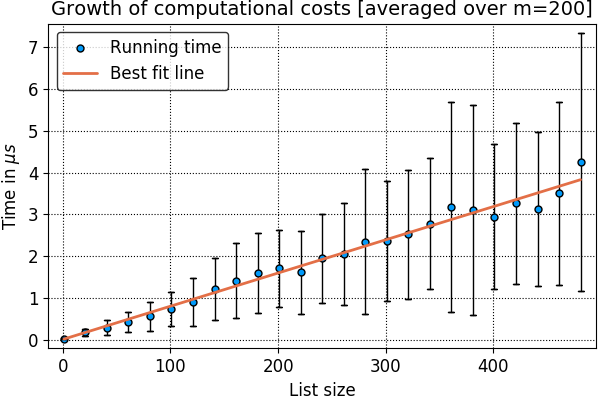

In [54]:
m=200
x=1:20:500
Time,Std=Cost_lin_interval(x,m)    #NUMBER 2.3 IN FILE
a,b=linreg(x,Time)
println("The gradient of the best fit line is")
println(b)
scatter(x,Time*1e6,yerr=Std*1e6,markersize=5, linewidth=2, label="Running time",xlabel="List size",ylabel=L"Time in $\mu s$",title="Growth of computational costs [averaged over m=200]")
plot!(x,(b*x+a)*1e6,linewidth=2,label="Best fit line")

We plot on a lin/lin plot and fit the best fit line. As we average, we also plot the standard deviation. The plot shows that the computational cost of the list search grows linearly. 

#### Question 2 Part 3
We use the function "buildFTree" to turn a list in a fenwick tree. We want to use the fenwick tree to solve the interval membership problem. To do that we implement the fast search algorithm as a function "intervalmembership_tree". It gives back the intervalmembership of a value x which is drawn from the correct range.  

In [ ]:
function intervalmembership_tree(FT::Nullable{FTree},x::Float64) #the input needs to be of the type "Nullable{LList}", "Int64" #NUMBER 2.4 IN FILE
    l=get(FT).left                            #let l be the left subtree
    r=get(FT).right                           #let r be the right subtree
    k=get(FT).data                            #let k be the stored KVPair
    if (isnull(l)==true && isnull(r)==true)   #if both subtrees are empty, we are in a leaf and found the interval
        return(k)                                             
        elseif (isnull(l) ==false && x<get(l).data.value) #if the leftsubtree is not empty and x is smaller than the key value stored there go left
            intervalmembership_tree(l,x)      #repeat the process with the left subtree
        elseif (isnull(r)==false)             # if the rightsubtree is not empty and we're not in one of the previous cases
            x=x-get(l).data.value             #update x to be x-key value of the left subtree  
            intervalmembership_tree(r,x)      #repeat the process with the right subtree
    end
end

We build a fenwick tree and check for a small value of n (n=10) that the function works, using the function "intervallmembership" we defined above.

In [ ]:
lists=create_list_sumlist(10)   #NUMBER 2.5 IN FILE
L=buildLList(lists[2])
T = Nullable{FTree}(FTree(KVPair(0,0.0)))
T=buildFTree(T, lists[1])
C=lists[2]

## check 5 times 

for i=1:5
    y=rand()*C[i].value
    println(y)
    println(intervalmembership(L,y))
    println(intervalmembership_tree(T,y))
end 

As the interval indices match for both methods for small n we know that the function works correctly. We now want to find out how the computational effort of the fenwick tree method for solving the interval problem changes when we increase the size of the input list (and therefore the size of the tree). We again fix a maximal list size n and a number of repetitions per list size m. We increase our list size in powers of 2. We fix a list size, generate a tree, pick a random number from the correct range and compute the needed time for every iteration. We then take the mean of the needed running times and assign it as the y-value for the associated list size.


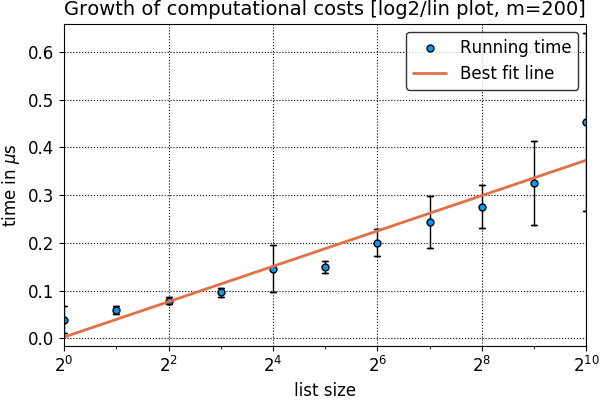

In [57]:
m=200
x=0:1:10
x=2.^(x)
Time,Std=Cost_tree_interval(x,m)  #NUMBER 2.6 IN FILE
a,b=linreg(log2(x),Time*1e6)
scatter(x,Time*1e6,yerr=Std*1e6, linewidth=2, label="Running time",xlabel="list size",ylabel=L"time in $\mu$s",xscale=:log2,markersize=5,title="Growth of computational costs [log2/lin plot, m=200]")
plot!(x,(b*log2(x)+a),linewidth=2,label="Best fit line")

We plot on a log2/lin plot and fit the best fit line. As we average, we also plot the standard deviation. As we can fit a linear function on a log2/lin scale, the computational cost is growing logratihmically. For big list sizes,we therefore expect the second method to be much faster than the first one. To emphasize this, we run both methods at the same time and instead of plotting the individual running times of both we plot the difference of the running times.


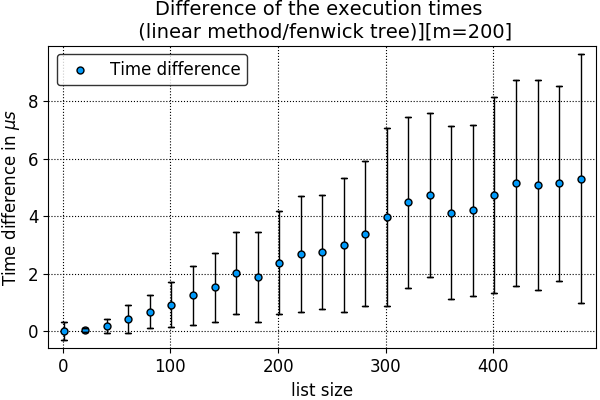

In [62]:
n=500
x=1:20:n
m=200
Time,Std=time_compare(x,m) #NUMBER 2.7 IN FILE

scatter(x,Time*1e6,yerr=Std*1e6, linewidth=2,markersize=5, label="Time difference",xlabel="list size",ylabel=L"Time difference in $\mu s$",title="Difference of the execution times \n (linear method/fenwick tree)][m=200]")

We plot on a lin/lin plot. As we average, we also plot the standard deviation. The plot shows that the computational cost of the list search grows linearly. The time difference is growing linearly, as expected the second method is much faster than the first one. The bigger the list size the more important becomes the difference. 

## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$

118
124
136
90
10
47
65
72
183
168
56
20
44
176
187
30
166
4
162
133
89
191
74
12
190
33
183
106
183
87
64
65
157
137
175
64
192
158
76
57
112
135
39
77
121
109
8
35
21
155
40
172
181
86
132
115
149
190
52
102
35
142
30
51
197
151
183
176
181
53
194
111
114
183
101
129
74
44
125
21
167
176
111
168
53
114
37
173
16
91
169
187
112
4
68
90
165
39
163
65
195
116
30
132
184
101
76
149
175
170
1
24
188
175
127
173
80
6
111
183
78
196
132
191
90
118
127
79
184
123
55
179
92
92
72
140
156
164
44
10
1
194
114
43
31
178
7
66
54
140
85
8
195
111
147
73
77
65
118
154
181
151
62
63
57
125
91
133
119
32
125
171
66
51
144
131
177
16
164
10
65
58
126
131
130
133
112
73
15
121
186
20
56
198
81
178
183
36
188
61
123
107
193
161
112
74
199
159
130
66
185
10
104
116
65
175
41
93
97
86
46
94
160
117
124
66
48
176
127
108
173
6
77
4
88
67
179
156
30
100
61
106
6
199
16
18
90
178
20
160
161
45
11
197
9
99
24
175
4
82
194
111
86
185
196
173
58
159
48
12
9
33
169
62
193
111
111
136
61
106
182
199
41
148
155
93

66
91
103
171
180
144
98
126
63
141
35
62
30
166
51
83
1
8
189
139
76
97
26
64
59
70
25
127
72
150
49
110
189
150
149
130
38
50
68
70
197
149
46
119
164
144
21
85
27
158
147
200
164
49
165
79
34
29
119
192
163
57
176
185
10
9
16
169
37
103
165
91
120
115
88
153
86
182
3
53
138
124
64
196
146
93
3
108
183
19
65
9
33
165
121
119
146
160
8
57
41
23
184
134
54
156
55
56
5
130
159
85
50
29
163
189
192
167
96
194
97
112
28
172
188
35
11
103
35
195
171
125
175
145
59
142
24
41
148
132
39
97
171
175
181
196
146
34
127
131
68
162
57
105
83
108
95
96
180
33
12
74
56
178
193
136
21
159
31
15
133
114
131
120
66
152
150
188
145
129
52
109
178
140
111
23
85
102
48
78
63
141
102
156
45
9
61
127
78
179
3
145
42
155
57
16
162
5
39
69
149
69
186
97
200
41
59
150
10
55
102
69
78
36
2
65
82
50
57
124
148
134
138
25
117
181
172
152
89
8
30
181
65
33
83
20
198
10
190
37
56
180
172
79
126
121
4
12
86
64
49
98
69
74
87
146
36
197
37
186
93
4
163
160
160
14
16
42
41
59
151
150
183
88
29
36
46
91
49
115
148
52


11
143
101
164
192
162
152
1
99
193
14
168
161
30
116
143
85
194
168
96
139
53
128
42
71
155
18
69
79
146
2
50
174
86
196
61
39
74
22
103
105
71
189
71
130
99
117
33
95
51
117
119
82
142
194
170
150
162
40
75
98
20
53
145
27
123
119
169
104
56
4
197
153
54
86
68
125
76
152
199
16
57
144
31
133
54
62
178
197
119
85
54
76
49
20
166
64
25
8
4
164
20
64
16
166
104
103
134
36
30
160
183
116
27
79
191
15
160
179
78
113
11
156
198
123
24
171
172
68
2
33
73
30
31
155
159
160
25
152
3
118
200
88
31
22
72
112
166
123
134
140
113
129
52
126
135
177
23
157
173
188
118
137
129
97
94
31
4
69
35
131
126
51
103
174
148
104
2
132
22
80
59
52
200
199
185
38
23
139
33
128
163
40
132
196
55
22
158
193
85
8
119
97
6
77
123
79
62
106
57
180
38
179
75
89
44
102
2
112
89
35
142
82
170
68
174
99
162
100
6
134
14
15
149
196
146
136
106
37
47
53
84
55
74
155
183
107
152
182
33
17
66
2
5
114
63
178
17
193
48
111
125
172
184
31
45
30
82
15
1
64
180
170
123
23
166
115
183
68
194
154
162
127
10
70
199
153
20
193
194


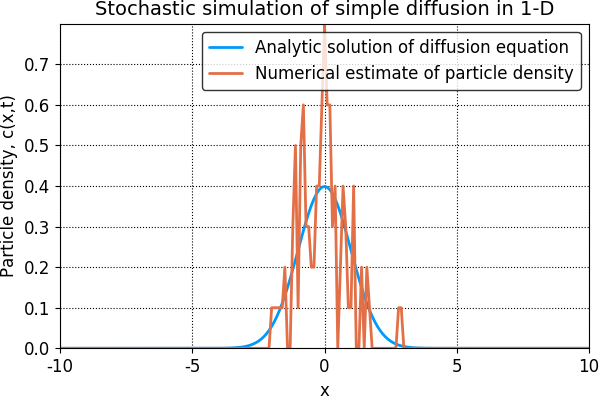

In [72]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1.0
t=0.0


r = (D/2.0)/(dx*dx)
totalRate = 2.0*N*r
dt = 1.0/totalRate
T=1.0

# This is the main loop
while t < T
    # Pick an event
    k = rand(1:2*N)
    println(k)
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation",linewidth=2)
plot!(X, P, label="Numerical estimate of particle density",linewidth=2)
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?

**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.



#### Question 3 Part 1
We consider the model from above but assume that the rates are drawn from an exponential distribution with mean D. We modify the algorithm with account to that. If we pick an event, in order to find out in which way we hop, we need to solve an interval membership problem. To do that, we first use the linear search defined above. We embedd the modified process in the funcion "particle_linear". A detailed description of all that was modified can be found in function 3.1 in the file.


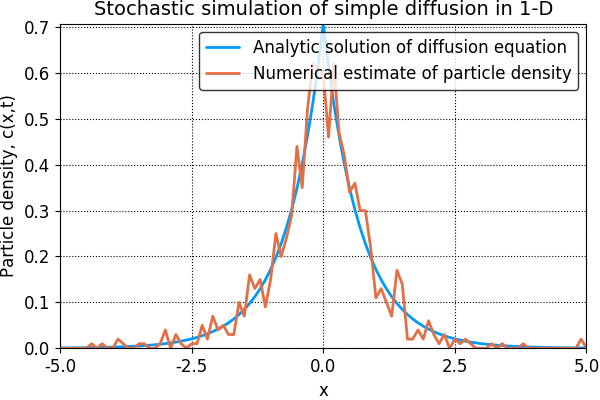

In [95]:
D=1.0
T=1.0
X,P=particle_linear(1000)
P1 = normal(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation",linewidth=2)
plot!(X, P, label="Numerical estimate of particle density",xlim=(-5,5),linewidth=2)
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

In order to measure the computational effort we embedd our process in the function "particle_linear", which takes N (number of particles) as an input argument. We want to see how our computational effort changes if we increase the particle number of particles.


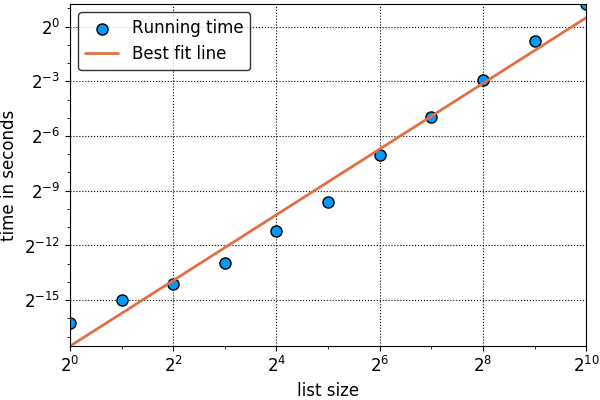

In [116]:
x=0:1:10
x=2.^x
Time=zeros(length(x))
counter=1
for i in x
    Time[counter] = (@timed  particle_linear(Int(i)))[2]
    counter=counter+1
end 
a,b=linreg(log2(x),log2(Time))
scatter(x,Time,markersize=8,label="Running time",xlabel="list size",ylabel="time in seconds",xscale=:log2,yscale=:log2)
plot!(x,2.^(b*log2(x)+a),linewidth=2,label="Best fit line")

In [85]:
function particle_tree(N)
    L=10.0
    N=1000
    Nx = 201
    dx = 2.0*L/(Nx-1)
    X = dx.*(-(Nx-1)/2:(Nx-1)/2)
    Y =zeros(Int64,N)
    D = 1.0
    t=0.0

    #draw the rates from an exponential distribution
    Rates=zeros(2*N)
    Rates[1:N]=randexp(N)*D
    Rates[N+1:2N]=Rates[1:N]
    Rates=Rates.*(1/2(dx*dx))
    #calculate the total rate
    totalRate=sum(Rates)
    #scale the time 
    dt = 1.0/totalRate

    KV_Rates_tree=Array{KVPair}(2*N)

    for i=1:2*N
        x=Rates[i]
        KV_Rates_tree[i]=KVPair(i,x)
    end
    Tree = Nullable{FTree}(FTree(KVPair(0,0.0)))
    Tree=buildFTree(Tree, KV_Rates_tree)

    # particle=rand()*totalRate

    # intervalmembership(Rates_list,particle)


    T=1.0

    #This is the main loop
    while t < T
    #     # Pick an event
        k = rand()*totalRate
        interval=intervalmembership_tree(Tree,k)
          interval=interval.key
        if interval<=N
            hop = 1
            particleId = interval
        else
            hop = -1
            particleId=interval-N
        end
        Y[particleId]+=hop
        t+=dt
    end

    #Calculate the estimated density of particles
    P =zeros(Float64,length(X))
    for i in 1:length(Y)
        P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
    end
    return X,P
end


particle_tree (generic function with 1 method)

In [86]:
particle_tree(1000)

(-10.0:0.1:10.0,[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])


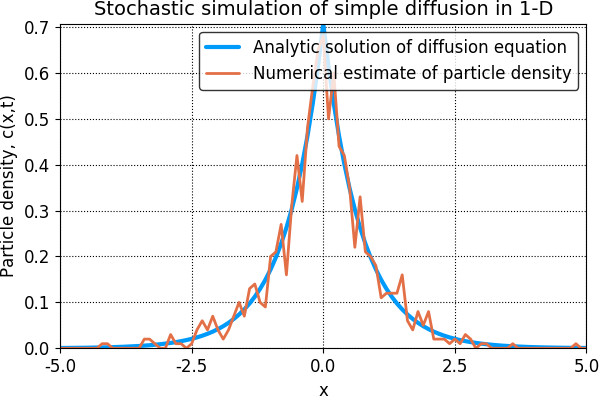

In [93]:
D=1.0
T=1.0
X,P=particle_tree(Int(1e6))
P1 = normal(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation",linewidth=3,xlim=(-5,5))
plot!(X, P, label="Numerical estimate of particle density",linewidth=2)
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

In [ ]:
s=18
Time=zeros(s)
x=logspace(1,s,s)
counter=1
for i in x
    Time[counter] = (@timed  particle_tree(Int(i)))[2]
    counter=counter+1
end 
scatter(x,Time,markersize=8,label="Running time",xlabel="list size",ylabel="time in seconds",xscale=:log10,yscale=:log10,xlim=(10^0.5,10^(s+0.5)),ylim=(10^(-5.5),10^1.5))

In [ ]:
## compare

a=@timed(particle_crap())[2]
b=@timed(particle_crap_tree())[2]
println(a-b)